# Drift of a randomly generated dataset

Tong Shu Li

To confirm that the drift behaviour observed in the dataset for PMID26623667 is a real biological effect, we will verify here that a randomly generated dataset exhibits no such drift behaviour.

Details of how this dataset was generated can be found in `../data/random/make_random_expset.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from itertools import product

In [2]:
sys.path.append("..")

In [3]:
from src.drift import calc_drift
from src.plots import plot_multi_density

In [4]:
%matplotlib inline
%load_ext rpy2.ipython

---

## Read random data

In [5]:
exp = pd.read_csv("../data/random/random_expset.tsv", sep = '\t')

In [6]:
exp.shape

(1000000, 8)

In [7]:
exp.head()

,gene_id,log_cpm,age,condition,replicate,cpm,ref_cpm,RLFEC
0,gene_0,5.707996,1,control,0,301.266626,100.435414,1.098481
1,gene_0,1.251806,1,control,1,3.496652,100.435414,-3.357709
2,gene_0,3.725502,1,control,2,41.492051,100.435414,-0.884013
3,gene_0,4.113772,1,control,3,61.177045,100.435414,-0.495743
4,gene_0,4.551186,1,control,4,94.744695,100.435414,-0.058329


---

## RLFEC distribution

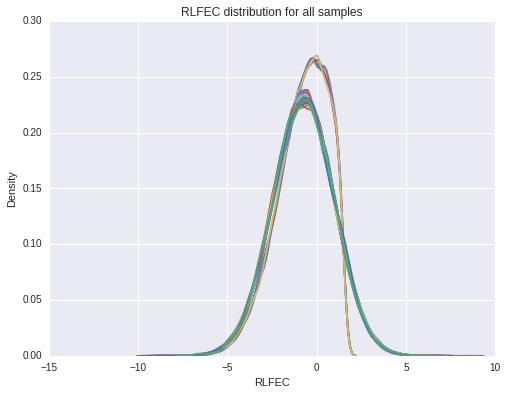

In [8]:
ax = plot_multi_density(
    exp, ["age", "condition", "replicate"], "RLFEC",
    rc = {"figure.figsize": (8, 6)}
)

ax.legend_.remove()
ax.set_title("RLFEC distribution for all samples")
ax.set_xlabel("RLFEC");

A subset of the samples seems to have a very different distribution profile. Let's determine which samples these are:

In [9]:
days = [1, 3, 5, 7, 10]
conditions = ["control", "drug"]
reps = 5

total = set((d, c, r) for d, c, r in product(days, conditions, range(reps)))
normal = exp.query("RLFEC > 4").groupby(["age", "condition", "replicate"]).groups.keys()

total - set(normal)

{(1, 'control', 0),
 (1, 'control', 1),
 (1, 'control', 2),
 (1, 'control', 3),
 (1, 'control', 4)}

We can see that the weird looking distributions are from the young reference.

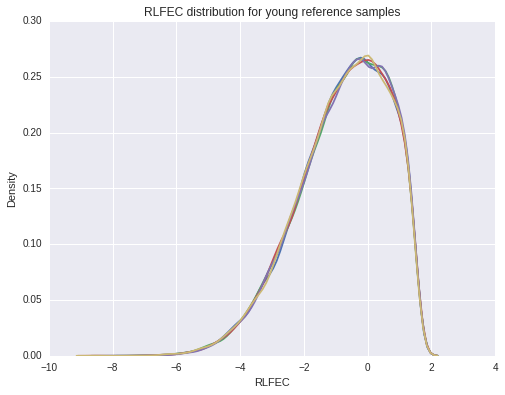

In [10]:
ax = plot_multi_density(
    exp.query("age == 1 & condition == 'control'"),
    ["age", "condition", "replicate"], "RLFEC",
    rc = {"figure.figsize": (8, 6)}
)

ax.legend_.remove()
ax.set_title("RLFEC distribution for young reference samples")
ax.set_xlabel("RLFEC");

## Calculate drift

Now we can calculate for the 20000 genes in this dataset.

In [11]:
drift = calc_drift(exp, ["age", "condition", "replicate"], "RLFEC")

In [12]:
drift.head()

,age,condition,replicate,drift
0,1,control,0,2.038282
1,1,control,1,2.049283
2,1,control,2,2.037082
3,1,control,3,2.026683
4,1,control,4,2.043976


## Plot drift

If we plot the entire dataset, we get a very strange scatterplot:

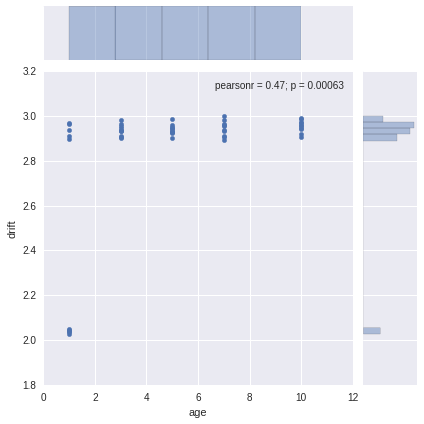

In [13]:
sns.jointplot(
    data = drift,
    x = "age", y = "drift"
);

The points at the bottom are caused by the young reference, which we recall had a strange looking RLFEC distribution. Removing it and replotting, we get:

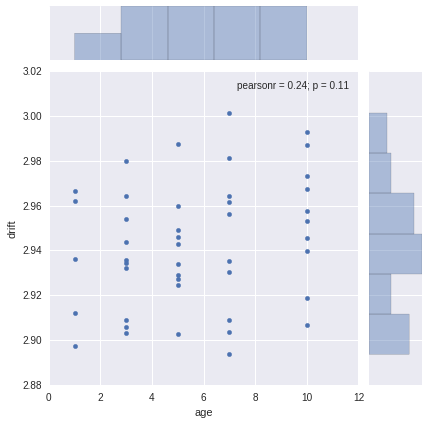

In [14]:
sns.jointplot(
    data = drift.query("~(age == 1 & condition == 'control')"),
    x = "age", y = "drift"
);

This random scatterplot is what we expect.

## Linear modeling

Let's do our usual linear modeling on the drift to see if there is any trend.

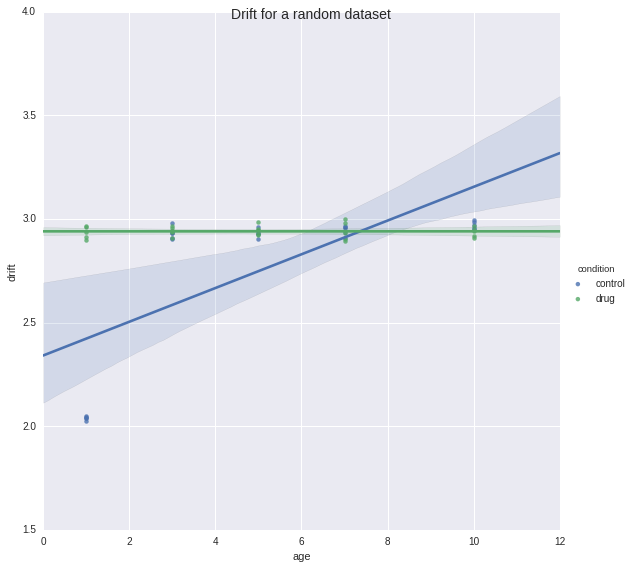

In [15]:
g = sns.lmplot(
    data = drift,
    x = "age", y = "drift", hue = "condition",
    size = 8
)

g.fig.suptitle("Drift for a random dataset", fontsize = 14);

In [16]:
%%R -i drift

summary(lm(drift ~ age + condition, data = drift))


Call:
lm(formula = drift ~ age + condition, data = drift)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56669 -0.07020  0.05681  0.14542  0.30491 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.55268    0.07143  35.736  < 2e-16 ***
age            0.04069    0.01047   3.887 0.000317 ***
conditiondrug  0.17591    0.06541   2.689 0.009874 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2313 on 47 degrees of freedom
Multiple R-squared:  0.3222,	Adjusted R-squared:  0.2934 
F-statistic: 11.17 on 2 and 47 DF,  p-value: 0.0001073



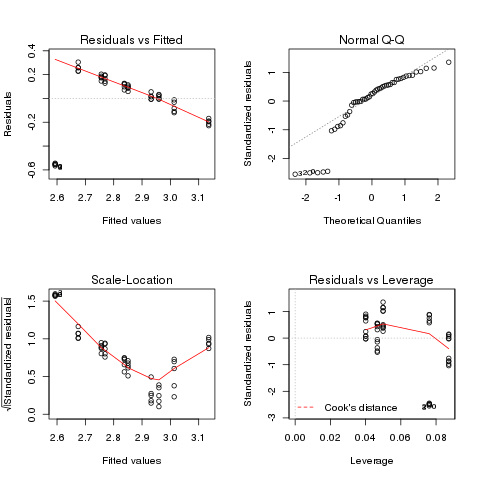

In [17]:
%%R -i drift

par(mfrow = c(2, 2))
plot(lm(drift ~ age + condition, data = drift))

Note that we have to be careful about how we do things. Including the young reference by default causes us to get a significant statistical model, even though we should be removing the young reference here due to its odd distribution.

## Redo with the young reference removed

In [18]:
good = drift.query("~(age == 1 & condition == 'control')")

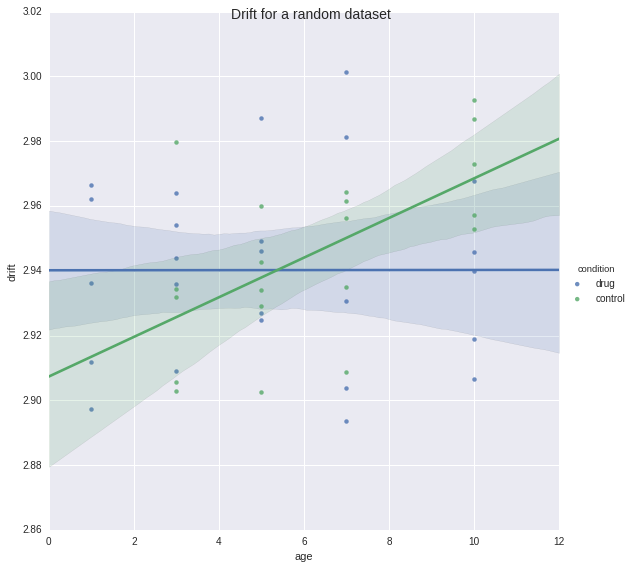

In [19]:
g = sns.lmplot(
    data = good,
    x = "age", y = "drift", hue = "condition",
    size = 8
)

g.fig.suptitle("Drift for a random dataset", fontsize = 14);

Now we see no trend anymore for drift with age.

In [20]:
%%R -i good

summary(lm(drift ~ age + condition, data = good))


Call:
lm(formula = drift ~ age + condition, data = good)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.050488 -0.015015 -0.000148  0.017092  0.057289 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.931997   0.010875 269.599   <2e-16 ***
age            0.002173   0.001429   1.521    0.136    
conditiondrug -0.003107   0.008464  -0.367    0.715    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02777 on 42 degrees of freedom
Multiple R-squared:  0.06106,	Adjusted R-squared:  0.01635 
F-statistic: 1.366 on 2 and 42 DF,  p-value: 0.2663



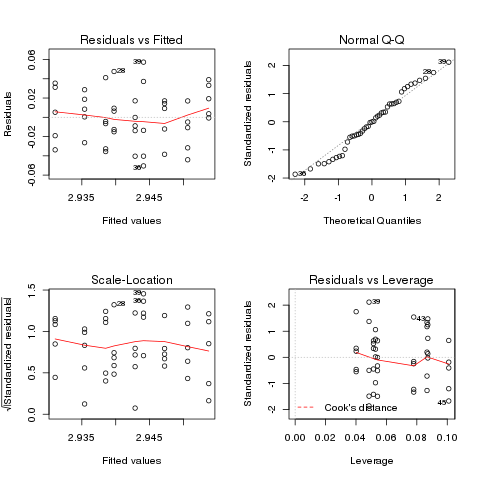

In [21]:
%%R -i good

par(mfrow = c(2, 2))
plot(lm(drift ~ age + condition, data = good))

With a randomly generated dataset, we see that the entire transcriptome is not drifting (there
is no trend). The linear model confirms this. However, if we included the young reference values, then a trend suddenly materializes.

# Conclusion

A randomly generated Gaussian dataset exhibits no drift behaviour, leading us to conclude that the dataset for PMID26623667 is not drifting purely due to random chance.